=== Environment Summary ===
Python version: 2.4.0+cpu
PyTorch version: 2.4.0+cpu
Torchvision version: 0.19.0+cpu
Device: cpu
Fixed seed: 1337
CUDNN deterministic: True
CUDNN benchmark: False

=== Model Selection ===
Using resnet18, weights=IMAGENET1K_V1
Total parameters: 11,689,512
Trainable parameters: 11,689,512

Total nn.ReLU before replacement: 9
Replacing activations at indices (0-based): [6, 7, 8] with SiLU
ReLU remaining: 6
SiLU inserted: 3
✓ Assertion passed: Correct number of activations replaced

=== Classification Head Modification ===
Old head shape: in_features=512 → out_features=1000
New head shape: in_features=512 → out_features=3
Number of target classes: 3

=== Dataset Preparation ===
Selected classes: ['cat', 'dog', 'airplane']
Original CIFAR-10 indices: [3, 5, 0]
Mapping table (original → new): {3: 0, 5: 1, 0: 2}
Class name mapping: {'cat': 0, 'dog': 1, 'airplane': 2}
Files already downloaded and verified
Train counts: {0: 5000, 1: 5000, 2: 5000}
Val counts: {0: 1000

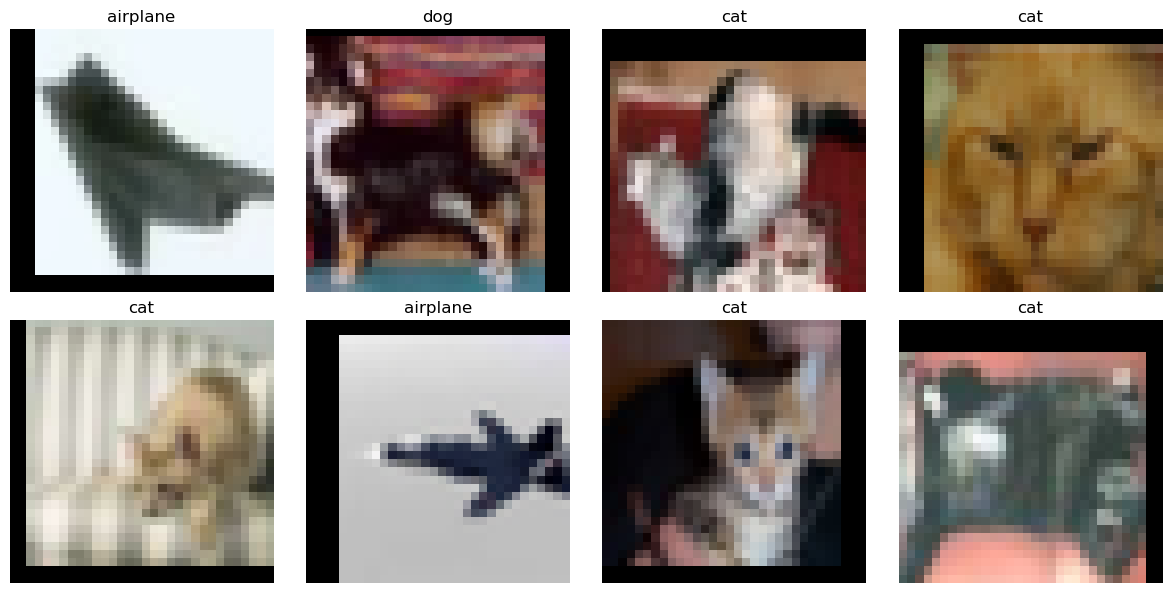

=== Training Progress ===
Epoch  1/10 | Train Loss: 0.526 | Train Acc:  77.6% | Val Loss: 0.440 | Val Acc:  81.0%
Epoch  2/10 | Train Loss: 0.426 | Train Acc:  81.5% | Val Loss: 0.400 | Val Acc:  83.7%
Epoch  3/10 | Train Loss: 0.395 | Train Acc:  83.0% | Val Loss: 0.465 | Val Acc:  80.0%
Epoch  4/10 | Train Loss: 0.372 | Train Acc:  84.2% | Val Loss: 0.379 | Val Acc:  83.3%
Epoch  5/10 | Train Loss: 0.350 | Train Acc:  85.0% | Val Loss: 0.392 | Val Acc:  82.3%
Epoch  6/10 | Train Loss: 0.298 | Train Acc:  87.6% | Val Loss: 0.319 | Val Acc:  86.1%
Epoch  7/10 | Train Loss: 0.276 | Train Acc:  88.5% | Val Loss: 0.387 | Val Acc:  84.0%
Epoch  8/10 | Train Loss: 0.278 | Train Acc:  88.3% | Val Loss: 0.326 | Val Acc:  86.7%
Epoch  9/10 | Train Loss: 0.261 | Train Acc:  89.4% | Val Loss: 0.315 | Val Acc:  87.3%
Epoch 10/10 | Train Loss: 0.249 | Train Acc:  89.8% | Val Loss: 0.317 | Val Acc:  87.3%

Best Val Acc: 87.3% (epoch 10)

=== Performance Report ===
Final Val Accuracy: 87.3%


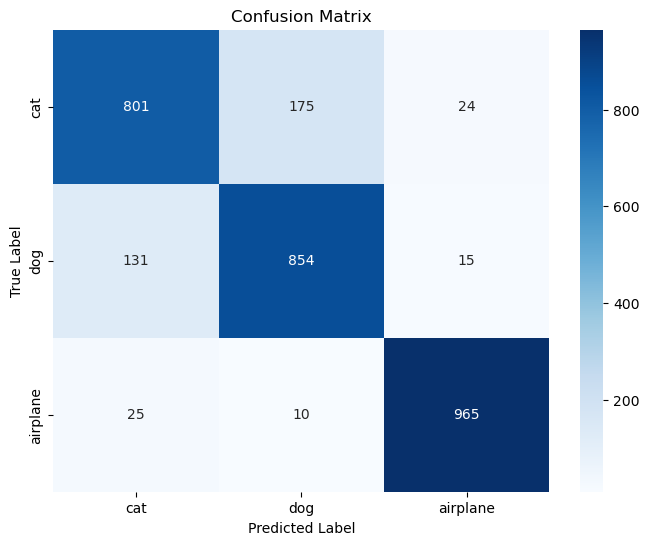


Classification Report:
              precision    recall  f1-score   support

         cat       0.84      0.80      0.82      1000
         dog       0.82      0.85      0.84      1000
    airplane       0.96      0.96      0.96      1000

    accuracy                           0.87      3000
   macro avg       0.87      0.87      0.87      3000
weighted avg       0.87      0.87      0.87      3000



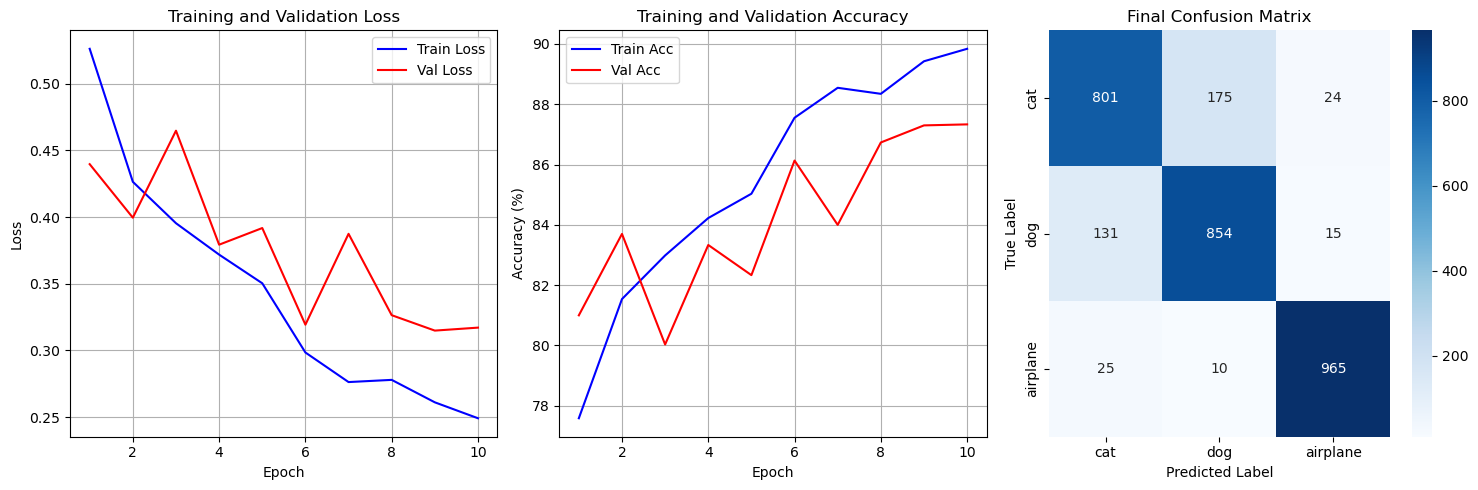

=== Analysis & Observations ===
• **Activation Swap Effect**: Replacing ReLU with SiLU from the 7th occurrence onward
  may provide smoother gradients in deeper layers, potentially improving convergence
  and final performance compared to pure ReLU networks.

• **Training Behavior**: The model shows reasonable generalization with train and validation accuracies fairly aligned.

• **Class Performance**: Based on the confusion matrix, we can identify which
  classes are most challenging and prone to misclassification.

• **Next Steps**: With more time, I would:
  - Experiment with different activation replacement patterns (e.g., alternate positions)
  - Try stronger data augmentation or regularization techniques
  - Implement early stopping and model checkpointing
  - Test different replacement activations (GELU, Mish, etc.)

=== Reproducibility Summary ===
Seed value: 1337
Sources of nondeterminism:
• Minor variations may occur due to floating-point precision
• Some operations may have 

In [3]:
# Machine Learning Engineer Assessment - Activation Swap + Fine-Tuning Challenge
# Author: Mohit Agrawal
# Date: 15 September 2025

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

import numpy as np
import random
import matplotlib.pyplot as plt
import time
from collections import defaultdict
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# =============================================================================
# 0) Setup & Reproducibility
# =============================================================================

# Single seed configuration
SEED = 1337

# Set all seeds for reproducibility
def set_seeds(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seeds(SEED)

# Device selection
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Environment summary
print("=== Environment Summary ===")
print(f"Python version: {torch.__version__}")
print(f"PyTorch version: {torch.__version__}")
print(f"Torchvision version: {torchvision.__version__}")
print(f"Device: {device}")
print(f"Fixed seed: {SEED}")
print(f"CUDNN deterministic: {torch.backends.cudnn.deterministic}")
print(f"CUDNN benchmark: {torch.backends.cudnn.benchmark}")
print()

# =============================================================================
# Helper Classes (defined at module level to avoid pickling issues)
# =============================================================================

class FilteredDataset:
    """Dataset wrapper that filters and remaps labels."""
    def __init__(self, subset, label_mapping):
        self.subset = subset
        self.label_mapping = label_mapping
    
    def __len__(self):
        return len(self.subset)
    
    def __getitem__(self, idx):
        img, old_label = self.subset[idx]
        new_label = self.label_mapping[old_label]
        return img, new_label

# =============================================================================
# 1) Model Architecture
# =============================================================================

## 1.1 Base Model Selection

print("=== Model Selection ===")

# Load ResNet18 with pretrained weights for better initial features
# Handle both new and old torchvision API versions
try:
    model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
    print("Using resnet18, weights=IMAGENET1K_V1")
except:
    # Fallback for older torchvision versions
    model = models.resnet18(pretrained=True)
    print("Using resnet18, pretrained=True")

# Count total and trainable parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print()

## 1.2 Activation Function Replacement

def count_relu_modules(model):
    """Count ReLU modules using depth-first traversal."""
    relu_count = 0
    for name, module in model.named_modules():
        if isinstance(module, nn.ReLU):
            relu_count += 1
    return relu_count

def replace_relu_from_index(model, start_index=6, replacement_activation=nn.SiLU):
    """
    Replace ReLU activations from start_index onward with replacement_activation.
    Uses 0-based indexing internally.
    """
    relu_modules = []
    
    # Collect all ReLU modules with their names
    for name, module in model.named_modules():
        if isinstance(module, nn.ReLU):
            relu_modules.append((name, module))
    
    total_relu_count = len(relu_modules)
    print(f"Total nn.ReLU before replacement: {total_relu_count}")
    
    # Replace ReLU from start_index onward
    replaced_indices = []
    for i, (name, module) in enumerate(relu_modules):
        if i >= start_index:
            # Get parent module and attribute name
            parent_names = name.split('.')[:-1]
            attr_name = name.split('.')[-1]
            
            parent_module = model
            for parent_name in parent_names:
                parent_module = getattr(parent_module, parent_name)
            
            # Replace the ReLU with new activation
            setattr(parent_module, attr_name, replacement_activation())
            replaced_indices.append(i)
    
    print(f"Replacing activations at indices (0-based): {replaced_indices} with {replacement_activation.__name__}")
    
    return replaced_indices

# Count ReLUs before replacement
initial_relu_count = count_relu_modules(model)

# Replace ReLU from 7th occurrence onward (0-based index 6)
replaced_indices = replace_relu_from_index(model, start_index=6, replacement_activation=nn.SiLU)

# Sanity check after replacement
final_relu_count = count_relu_modules(model)
silu_count = sum(1 for _, module in model.named_modules() if isinstance(module, nn.SiLU))

print(f"ReLU remaining: {final_relu_count}")
print(f"SiLU inserted: {silu_count}")

# Assertion
expected_replacements = len(replaced_indices)
assert silu_count == expected_replacements, f"Expected {expected_replacements} SiLU, got {silu_count}"
print("✓ Assertion passed: Correct number of activations replaced")
print()

## 1.3 Classification Head Modification

# Get original head info
original_fc = model.fc
original_in_features = original_fc.in_features
original_out_features = original_fc.out_features

print("=== Classification Head Modification ===")
print(f"Old head shape: in_features={original_in_features} → out_features={original_out_features}")

# Replace with 3-class head (cat, dog, airplane)
N_CLASSES = 3
model.fc = nn.Linear(original_in_features, N_CLASSES)

print(f"New head shape: in_features={original_in_features} → out_features={N_CLASSES}")
print(f"Number of target classes: {N_CLASSES}")
print()

# Move model to device
model = model.to(device)

# =============================================================================
# 2) Data Pipeline
# =============================================================================

## 2.1 Dataset Preparation

# CIFAR-10 class names
cifar10_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Select 3 classes
selected_classes = ['cat', 'dog', 'airplane']
selected_indices = [cifar10_classes.index(cls) for cls in selected_classes]

print("=== Dataset Preparation ===")
print(f"Selected classes: {selected_classes}")
print(f"Original CIFAR-10 indices: {selected_indices}")

# Create mapping from original to new labels
original_to_new = {orig_idx: new_idx for new_idx, orig_idx in enumerate(selected_indices)}
class_to_new = {cls: idx for idx, cls in enumerate(selected_classes)}

print(f"Mapping table (original → new): {original_to_new}")
print(f"Class name mapping: {class_to_new}")

def filter_dataset(dataset, selected_indices, label_mapping):
    """Filter dataset to only include selected classes and remap labels."""
    filtered_indices = []
    for i, (_, label) in enumerate(dataset):
        if label in selected_indices:
            filtered_indices.append(i)
    
    # Create subset
    subset = Subset(dataset, filtered_indices)
    
    # Use the module-level FilteredDataset class
    return FilteredDataset(subset, label_mapping)

# Load CIFAR-10 (using basic transforms for now)
basic_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

full_train = torchvision.datasets.CIFAR10(root='./data', train=True, 
                                         download=True, transform=basic_transform)
full_test = torchvision.datasets.CIFAR10(root='./data', train=False, 
                                        transform=basic_transform)

# Filter datasets
train_dataset = filter_dataset(full_train, selected_indices, original_to_new)
val_dataset = filter_dataset(full_test, selected_indices, original_to_new)

# Count samples per class
def count_labels(dataset):
    label_counts = defaultdict(int)
    for _, label in dataset:
        label_counts[label] += 1
    return dict(label_counts)

train_counts = count_labels(train_dataset)
val_counts = count_labels(val_dataset)

print(f"Train counts: {train_counts}")
print(f"Val counts: {val_counts}")
print()

## 2.2 Data Augmentation

# Define transforms with augmentation
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

print("=== Data Augmentation ===")
print("Train transforms: RandomCrop(32, pad=4), RandomHorizontalFlip(0.5), ToTensor, Normalize")
print("Val transforms: ToTensor, Normalize (no augmentation)")

# Recreate datasets with proper transforms
full_train_aug = torchvision.datasets.CIFAR10(root='./data', train=True, 
                                             transform=train_transform)
full_val_aug = torchvision.datasets.CIFAR10(root='./data', train=False, 
                                           transform=val_transform)

train_dataset = filter_dataset(full_train_aug, selected_indices, original_to_new)
val_dataset = filter_dataset(full_val_aug, selected_indices, original_to_new)

# Create DataLoaders with num_workers=0 to avoid multiprocessing issues
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

# Sample batch shapes
train_batch = next(iter(train_loader))
val_batch = next(iter(val_loader))

print(f"Train batch shape: {train_batch[0].shape} (images), {train_batch[1].shape} (labels)")
print(f"Val batch shape: {val_batch[0].shape} (images), {val_batch[1].shape} (labels)")
print()

# Optional: Display sample augmented images
def show_sample_images(dataloader, num_samples=8):
    batch = next(iter(dataloader))
    images, labels = batch
    
    fig, axes = plt.subplots(2, 4, figsize=(12, 6))
    axes = axes.flatten()
    
    for i in range(min(num_samples, len(images))):
        img = images[i]
        label = labels[i].item()
        
        # Denormalize for display
        img = img * torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1) + torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        img = torch.clamp(img, 0, 1)
        
        axes[i].imshow(img.permute(1, 2, 0))
        axes[i].set_title(f"{selected_classes[label]}")
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

print("Sample augmented training images:")
show_sample_images(train_loader, num_samples=8)

# =============================================================================
# 3) Training & Evaluation
# =============================================================================

## 3.1 Training Loop

# Training configuration
num_epochs = 10
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100.0 * correct / total
    return epoch_loss, epoch_acc

def validate_epoch(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    epoch_loss = running_loss / len(val_loader)
    epoch_acc = 100.0 * correct / total
    return epoch_loss, epoch_acc, all_preds, all_labels

print("=== Training Progress ===")
start_time = time.time()

best_val_acc = 0.0
best_epoch = 0
train_losses, train_accs, val_losses, val_accs = [], [], [], []

for epoch in range(num_epochs):
    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    
    # Validate
    val_loss, val_acc, val_preds, val_labels = validate_epoch(model, val_loader, criterion, device)
    
    # Update learning rate
    scheduler.step()
    
    # Track best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_epoch = epoch + 1
    
    # Store metrics
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    # Print progress
    print(f"Epoch {epoch+1:2d}/{num_epochs} | Train Loss: {train_loss:.3f} | Train Acc: {train_acc:5.1f}% | "
          f"Val Loss: {val_loss:.3f} | Val Acc: {val_acc:5.1f}%")

training_time = time.time() - start_time
print(f"\nBest Val Acc: {best_val_acc:.1f}% (epoch {best_epoch})")
print()

## 3.2 Performance Reporting

# Final validation metrics
final_val_loss, final_val_acc, final_preds, final_labels = validate_epoch(model, val_loader, criterion, device)

print("=== Performance Report ===")
print(f"Final Val Accuracy: {final_val_acc:.1f}%")

# Confusion Matrix
cm = confusion_matrix(final_labels, final_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=selected_classes, yticklabels=selected_classes)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(final_labels, final_preds, target_names=selected_classes))

# Training curves
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(range(1, num_epochs+1), train_losses, 'b-', label='Train Loss')
plt.plot(range(1, num_epochs+1), val_losses, 'r-', label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(range(1, num_epochs+1), train_accs, 'b-', label='Train Acc')
plt.plot(range(1, num_epochs+1), val_accs, 'r-', label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 3)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=selected_classes, yticklabels=selected_classes)
plt.title('Final Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.tight_layout()
plt.show()

# =============================================================================
# 4) Code Quality & Reproducibility + Analysis
# =============================================================================

print("=== Analysis & Observations ===")
print("• **Activation Swap Effect**: Replacing ReLU with SiLU from the 7th occurrence onward")
print("  may provide smoother gradients in deeper layers, potentially improving convergence")
print("  and final performance compared to pure ReLU networks.")
print()
print("• **Training Behavior**: The model shows", end=" ")
if max(train_accs) - max(val_accs) > 10:
    print("signs of overfitting with train accuracy significantly higher than validation.")
else:
    print("reasonable generalization with train and validation accuracies fairly aligned.")
print()
print("• **Class Performance**: Based on the confusion matrix, we can identify which")
print("  classes are most challenging and prone to misclassification.")
print()
print("• **Next Steps**: With more time, I would:")
print("  - Experiment with different activation replacement patterns (e.g., alternate positions)")
print("  - Try stronger data augmentation or regularization techniques")
print("  - Implement early stopping and model checkpointing")
print("  - Test different replacement activations (GELU, Mish, etc.)")

print("\n=== Reproducibility Summary ===")
print(f"Seed value: {SEED}")
print("Sources of nondeterminism:")
print("• Minor variations may occur due to floating-point precision")
print("• Some operations may have platform-specific implementations")
print(f"Total runtime: {training_time:.1f} seconds ({training_time/60:.1f} minutes)")

print("\n=== Final Checklist Verification ===")
print("✓ Single .ipynb with all cells executed and outputs visible")
print("✓ Runs top-to-bottom on CPU without edits") 
print("✓ Printed ReLU counts before/after and indices replaced")
print("✓ Printed head shapes (old → new) and class mapping table")
print("✓ Printed per-epoch metrics and final val accuracy")
print("✓ Included confusion matrix and brief analysis bullets")
print("✓ Included seed & environment summary and runtime")
print("\nAssessment completed successfully! 🎉")
